In [559]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
from typing import List

In [41]:
np.linspace(0,10, 20)

array([ 0.        ,  0.52631579,  1.05263158,  1.57894737,  2.10526316,
        2.63157895,  3.15789474,  3.68421053,  4.21052632,  4.73684211,
        5.26315789,  5.78947368,  6.31578947,  6.84210526,  7.36842105,
        7.89473684,  8.42105263,  8.94736842,  9.47368421, 10.        ])

In [30]:
np.sin(np.linspace(0,10, 20)*(2*np.pi/10))

array([ 0.00000000e+00,  3.24699469e-01,  6.14212713e-01,  8.37166478e-01,
        9.69400266e-01,  9.96584493e-01,  9.15773327e-01,  7.35723911e-01,
        4.75947393e-01,  1.64594590e-01, -1.64594590e-01, -4.75947393e-01,
       -7.35723911e-01, -9.15773327e-01, -9.96584493e-01, -9.69400266e-01,
       -8.37166478e-01, -6.14212713e-01, -3.24699469e-01, -2.44929360e-16])

In [53]:
(datetime.strptime("2021-01-01", "%Y-%m-%d") - datetime.strptime("2021-01-31", "%Y-%m-%d")).days

-30

In [55]:
def add_seasonality(start_date, end_date, periodicity, freq='D'):
    """
    Function that creates a sinusoidal time series

    Parameters
    ------------
    start_date (datetime):
        The start_date for the series
    end_date (datetime):
        The end date for the series
    periodicity (float):
        The desired cycle length
    freq (str) = 'D':
        The freq for generating the datetime series

    Returns
    ------------
    A pd.series.Series object with a series of specified periodicity
    """
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    date_series = pd.date_range(start = start_date, end=end_date, freq=freq)
    series_len = len(date_series)
    x = np.linspace(0, series_len, series_len)
    y = np.sin(x* (2*np.pi/periodicity))

    date_series = pd.Series(data=y, index = date_series)

    return date_series


In [60]:
t = add_seasonality(start_date="2021-01-01", end_date='2022-03-31', periodicity=(365.254))

In [578]:
## Function for generating the sales data

def generate_sales_data(start_date:str, end_date:str,
 mean_sales:float, error_sd:float, seasonality:List[str],
 trt_start_date:str = '2021-01-01', is_exposed = False, trt_duration_days:int = 30,
 trend:float = 0.0, freq = 'D'):

    """
    A function which generates an additive sales data model with the given mean, trend, variance and seasonality 
    within the specified period.

    Parameters
    -------------
    start_date (str):
        The start date for the sequence
    end_date (str):
        End date
    mean_sales (float):
    errosr_sd (float):
    seasonality (List[str]):
        A list of desired seasonality. Should be from the list ['weekly', 'monthly', 'annually']
    trend (float) = 0.0:
        The total increase from the mean towards the end of the series
    freq (str) = 'D':
        The freq for creating the dataset
    """
    days_in_yr = 365.2422

    seasonal_dict = {'weekly':(days_in_yr/52), 'monthly':(days_in_yr/12), 'yearly':(days_in_yr)}
    date_series = pd.date_range(start = start_date, end=end_date, freq=freq)
    trend = np.linspace(0, trend, len(date_series), dtype=np.float64)

    if trt_start_date:
        treatment_outcome_zeros = pd.DataFrame(pd.Series(np.zeros(len(date_series)), index=date_series), columns=['zeros'])
        treatment_outcome_ones = (pd.DataFrame(pd.Series(np.ones(trt_duration_days),
         index = pd.date_range(start = trt_start_date, end = pd.to_datetime(trt_start_date) + timedelta(days = trt_duration_days-1))), columns=['ones']))
        treatment_outcome = treatment_outcome_zeros.join(treatment_outcome_ones).fillna(0).assign(total_trt = lambda d: d.zeros + d.ones).drop(['zeros', 'ones'], axis=1).total_trt

    sales_cyclicity = np.zeros(len(date_series), dtype=np.float64)

    for item in seasonality:
        sales_cyclicity = np.sum([sales_cyclicity, add_seasonality(start_date=start_date, end_date=end_date, periodicity=seasonal_dict[item], freq = freq)], axis=0)



    output = mean_sales + trend + sales_cyclicity + np.random.normal(loc = 0, scale=error_sd, size=len(date_series))
    max_output = output.max()
    output = np.clip(a = output, a_min = 0.0, a_max = max_output)

    output_pd_series = pd.Series(output, index = date_series, dtype=float)
    if is_exposed:
        output_pd_series = output_pd_series + treatment_outcome

    # output_pdf = (pd.DataFrame(output_pd_series, columns=['dollar_sales']).reset_index().assign(shopper_id = shopper_id)
    # .rename(columns = {'index':'date'}).pivot(columns = 'date', values = 'dollar_sales', index = 'shopper_id')
    # .reset_index(drop=True)
    # )

    return np.round(output_pd_series, 2)



In [581]:
t = generate_sales_data(start_date='2021-01-01', end_date='2022-03-31', mean_sales=3.0, trend = 5.5, error_sd=0.2,
 seasonality=['monthly', 'yearly'], trt_start_date="2021-09-01", is_exposed = True,trt_duration_days=50)

In [582]:
t

2021-01-01    2.88
2021-01-02    3.46
2021-01-03    3.47
2021-01-04    3.28
2021-01-05    3.82
              ... 
2022-03-27    8.74
2022-03-28    8.50
2022-03-29    8.70
2022-03-30    9.17
2022-03-31    9.18
Freq: D, Length: 455, dtype: float64

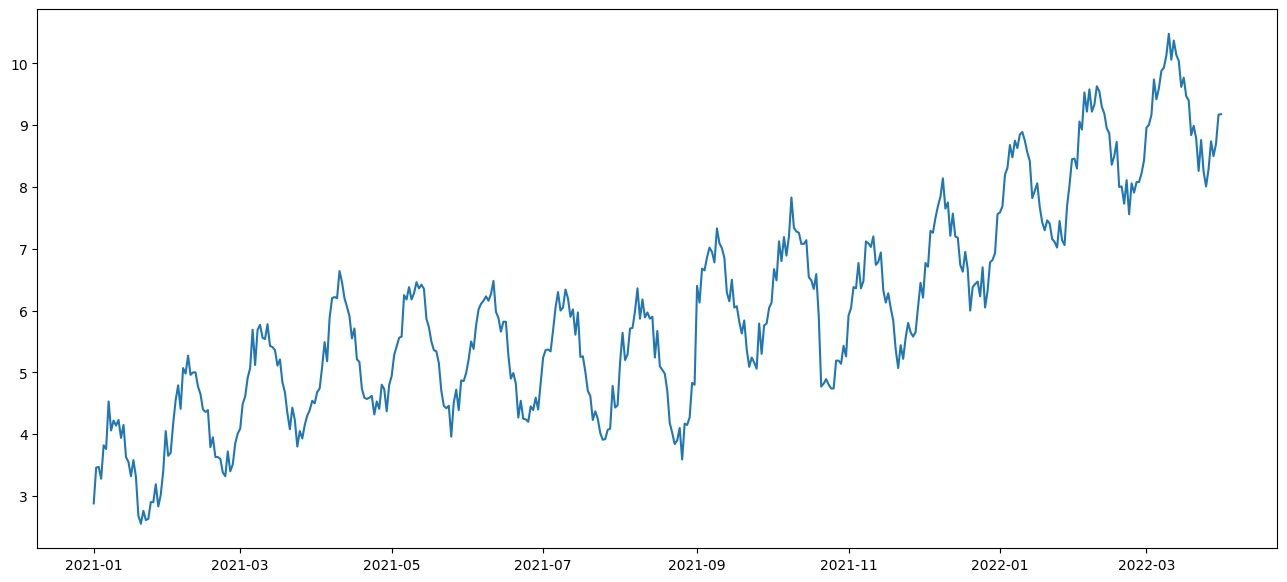

In [583]:
plt.figure(figsize=(16,7))
plt.plot(t)

In [211]:
t_np = np.array(t)

In [584]:
def generate_data(start_date:str = '2021-01-01', end_date:str = '2022-11-01', campaign_start_date = '2022-03-01', campaign_end_date = '2022-11-01', treatment_period:int = 60, trt_proportion:float = 0.1, total_obs:int = 1000):
    """
    Generates the time series data for the treatment and control group, given the proportion for each
    """
    num_exposed = int(total_obs * trt_proportion)
    is_exposed = np.repeat(a = 1, repeats=num_exposed)
    is_not_exposed = np.repeat(a = 0, repeats=total_obs - num_exposed)
    all_folks = np.concatenate([is_exposed, is_not_exposed], axis=-1)

    ## For the treated folks add 2 dollars for the time they are being treated

    output_df = pd.DataFrame({
        'shopper_id':np.random.randint(low=10000, high=99999, size=total_obs).astype(str),
        'shopper_mean':np.round(np.random.random(size=total_obs)*10, 2),
        'is_exposed':all_folks
    })#.set_index('shopper_id')

    output_df = (output_df.assign(campaign_start_date = pd.to_datetime(campaign_start_date)))

    # campaign_duration = pd.to_datetime(campaign_end_date) - pd.to_datetime(campaign_start_date)
    
    
    output_df = (output_df.assign(
        trt_start_date = lambda d: d.campaign_start_date.apply(lambda x : x + timedelta(np.random.randint(low = 0, high = treatment_period))))
        )

    get_sales = output_df.apply(lambda d: generate_sales_data(
        start_date=start_date, end_date=end_date, mean_sales=d.shopper_mean,
        trt_start_date= d.trt_start_date, is_exposed = bool(d.is_exposed),
        trend = 0.5, error_sd=2.0, seasonality=['monthly', 'yearly']), axis=1)
    get_sales = get_sales.reset_index(drop=True)

    output_df = pd.concat([output_df, get_sales], axis=1)

    

    return output_df

In [585]:
df = generate_data()
df

,shopper_id,shopper_mean,is_exposed,campaign_start_date,trt_start_date,2021-01-01 00:00:00,2021-01-02 00:00:00,2021-01-03 00:00:00,2021-01-04 00:00:00,2021-01-05 00:00:00,...,2022-10-23 00:00:00,2022-10-24 00:00:00,2022-10-25 00:00:00,2022-10-26 00:00:00,2022-10-27 00:00:00,2022-10-28 00:00:00,2022-10-29 00:00:00,2022-10-30 00:00:00,2022-10-31 00:00:00,2022-11-01 00:00:00
0,76194,9.18,1,2022-03-01,2022-04-15,10.85,6.25,7.98,10.60,9.44,...,9.04,3.66,10.72,6.20,8.90,4.94,8.08,10.76,8.03,11.00
1,55196,3.59,1,2022-03-01,2022-04-23,6.15,3.84,4.15,5.17,0.23,...,2.46,1.70,0.00,0.59,0.73,1.85,0.81,4.03,5.57,0.62
2,17427,7.70,1,2022-03-01,2022-03-21,8.29,2.79,10.13,8.82,12.87,...,5.77,8.67,8.10,6.59,2.51,10.15,5.24,7.00,9.95,3.50
3,56575,4.70,1,2022-03-01,2022-03-14,3.98,9.11,5.15,3.07,8.20,...,6.29,4.99,1.93,4.87,0.14,4.23,8.05,3.90,6.68,3.64
4,70212,7.88,1,2022-03-01,2022-03-11,9.34,6.91,8.90,7.45,12.60,...,5.79,6.90,6.20,3.50,4.70,4.52,5.91,10.48,7.03,10.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,46469,7.24,0,2022-03-01,2022-03-29,13.85,7.59,6.80,6.68,8.12,...,9.82,7.76,7.69,5.34,4.80,6.10,4.02,5.90,1.79,5.27
996,68601,0.59,0,2022-03-01,2022-04-17,0.25,0.23,0.00,0.97,3.39,...,0.00,2.09,0.00,2.02,0.00,0.00,0.00,0.63,2.25,1.62
997,66059,5.60,0,2022-03-01,2022-03-14,2.81,5.23,6.08,7.89,7.83,...,4.15,1.99,4.98,6.37,6.93,6.82,3.81,4.62,6.52,3.72
998,65071,6.08,0,2022-03-01,2022-03-31,3.87,4.89,5.54,6.76,3.52,...,3.76,5.05,5.48,6.31,4.93,6.02,8.11,4.68,5.73,5.13


In [562]:
df.iloc[:, 4:].shape[1]

670

In [563]:
df.iloc[0:1, 4:]

,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-09,2021-01-10,...,2022-10-23,2022-10-24,2022-10-25,2022-10-26,2022-10-27,2022-10-28,2022-10-29,2022-10-30,2022-10-31,2022-11-01
0,0.45051,4.731289,3.311939,3.447251,2.527372,5.242191,3.980763,4.432064,3.165736,3.729559,...,0.0,0.0,4.370819,3.00304,0.0,3.007266,0.998406,0.0,4.282208,2.213618


In [592]:
df2 = df.drop('campaign_start_date', axis=1).melt(id_vars=['shopper_id', 'is_exposed', 'trt_start_date', 'shopper_mean'], value_name='dollar_sales', var_name='date')

In [593]:
df2

,shopper_id,is_exposed,trt_start_date,shopper_mean,date,dollar_sales
0,76194,1,2022-04-15,9.18,2021-01-01,10.85
1,55196,1,2022-04-23,3.59,2021-01-01,6.15
2,17427,1,2022-03-21,7.70,2021-01-01,8.29
3,56575,1,2022-03-14,4.70,2021-01-01,3.98
4,70212,1,2022-03-11,7.88,2021-01-01,9.34
...,...,...,...,...,...,...
669995,46469,0,2022-03-29,7.24,2022-11-01,5.27
669996,68601,0,2022-04-17,0.59,2022-11-01,1.62
669997,66059,0,2022-03-14,5.60,2022-11-01,3.72
669998,65071,0,2022-03-31,6.08,2022-11-01,5.13


<AxesSubplot: xlabel='date', ylabel='dollar_sales'>

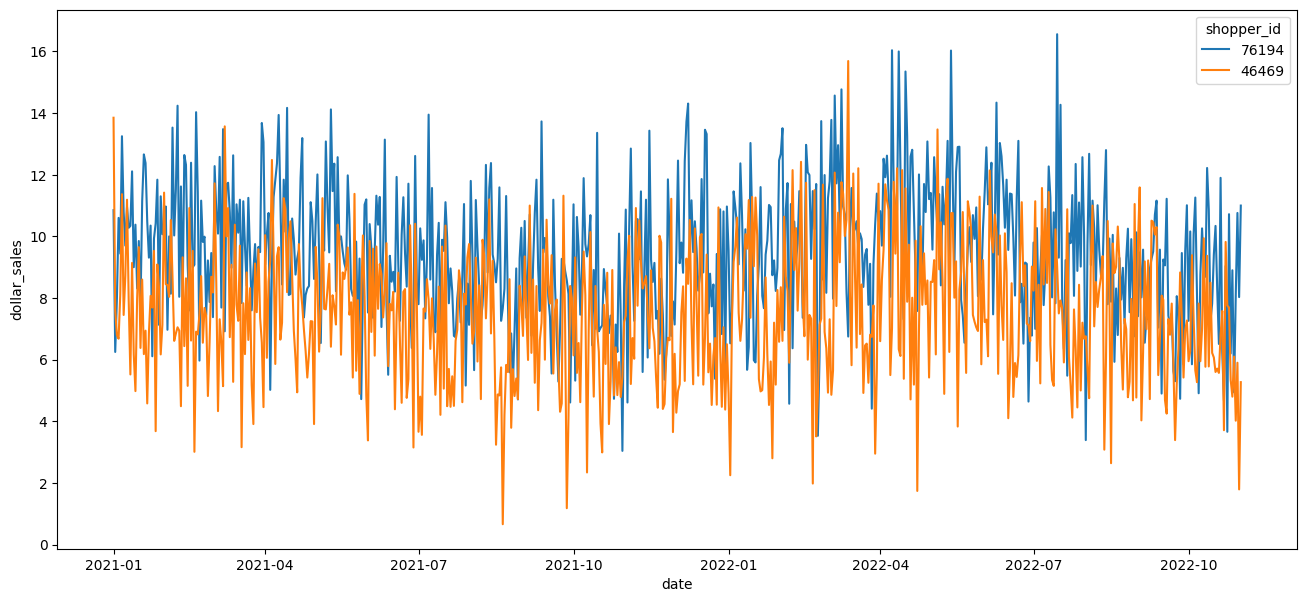

In [594]:
plt.figure(figsize=(16, 7))
sns.lineplot(x = 'date', y = 'dollar_sales', hue = 'shopper_id', data = df2.query("shopper_id in ['76194', '46469']"))


In [519]:
sales_df

,2021-01-01,2021-01-02,2021-01-03,2021-01-04,2021-01-05,2021-01-06,2021-01-07,2021-01-08,2021-01-09,2021-01-10,...,2022-10-23,2022-10-24,2022-10-25,2022-10-26,2022-10-27,2022-10-28,2022-10-29,2022-10-30,2022-10-31,2022-11-01
0,4.701059,0.574149,3.029512,6.782514,5.350551,5.455799,5.481613,3.417890,8.628731,8.383058,...,1.332149,0.496624,0.000000,3.465562,2.696325,5.123095,0.000000,1.232360,0.447039,2.300462
1,3.137019,0.000000,5.192728,2.689640,1.333722,4.410164,2.953686,6.385024,2.460532,5.415686,...,2.540624,1.118523,1.751619,0.086483,1.607843,3.365736,2.524005,0.675486,4.390237,6.119236
2,5.101132,5.311196,3.538230,1.860065,1.776568,0.053122,1.640584,2.969954,5.378694,1.782803,...,1.592470,1.658032,0.000000,2.745899,1.292649,2.326528,0.000000,0.057807,2.913931,2.314353
3,3.946626,8.116830,0.000000,3.050545,5.435566,9.591426,2.587906,0.000000,3.939326,6.820350,...,3.553741,0.577082,0.000000,4.285853,0.000000,5.221512,2.807247,3.580379,3.282135,0.040932
4,0.880378,3.112938,1.115811,0.439147,2.296327,0.934660,4.677130,3.107451,2.155935,6.247158,...,1.698987,2.518748,0.073901,0.000000,6.053876,1.360612,5.628479,3.243390,4.149100,7.753667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1.067214,0.029921,1.984428,4.903903,2.621712,5.029063,4.348654,3.553562,2.067612,4.115227,...,0.000000,2.461298,0.000000,2.708341,2.768825,0.527359,2.680090,0.000000,3.392000,2.136278
996,1.509511,6.297560,1.581296,5.424239,2.918617,3.939812,3.811492,5.147434,4.131349,3.833011,...,2.951554,1.768859,1.609516,4.081406,2.737601,3.828555,3.224653,2.056268,0.000000,1.958881
997,5.515149,7.407565,2.864280,5.620067,2.870516,3.458657,2.751594,6.631510,4.938631,5.565398,...,2.291683,0.451550,1.308932,3.061155,0.000000,0.007024,5.387129,0.584013,2.285021,1.386045
998,2.972180,8.502257,4.693295,3.564196,1.950268,2.651172,1.753087,7.829105,3.948941,7.199585,...,1.974953,2.795355,0.000000,0.662724,3.951023,3.081181,1.815966,3.484297,4.092706,4.665804


In [492]:
df2 = (df.assign(cols = 
    lambda d : d.apply(lambda x:generate_sales_data(x[0], start_date = '2021-03-01', end_date = '2022-11-01', mean_sales=5.0, error_sd=1.0, seasonality=['monthly']), axis=1)
)
)

ValueError: Cannot set a DataFrame with multiple columns to the single column cols

In [1]:
from custom_modules.generate_data import GenerateData

In [2]:
tc = GenerateData(start_date="2021-01-01", end_date="2021-11-01", periodicity=['monthly'])

In [3]:
data = tc.generate_data(campaign_end_date="2021-11-01", campaign_start_date="2021-08-01")

In [5]:
data.sort_values(['shopper_id', 'trt_start_date'])

,shopper_id,is_exposed,trt_start_date,shopper_mean,date,dollar_sales
425,10095,0,2021-09-21,7.78,2021-01-01,8.73
1425,10095,0,2021-09-21,7.78,2021-01-02,5.96
2425,10095,0,2021-09-21,7.78,2021-01-03,8.84
3425,10095,0,2021-09-21,7.78,2021-01-04,7.97
4425,10095,0,2021-09-21,7.78,2021-01-05,8.73
...,...,...,...,...,...,...
300057,99839,1,2021-09-07,4.86,2021-10-28,5.27
301057,99839,1,2021-09-07,4.86,2021-10-29,6.78
302057,99839,1,2021-09-07,4.86,2021-10-30,4.96
303057,99839,1,2021-09-07,4.86,2021-10-31,7.17


In [487]:
df = df.apply(lambda x:generate_sales_data(x[0], start_date = '2021-03-01', end_date = '2022-11-01', mean_sales=5.0, error_sd=1.0, seasonality=['monthly']), axis=1)

In [488]:
pd.DataFrame(df)

,2021-03-01,2021-03-02,2021-03-03,2021-03-04,2021-03-05,2021-03-06,2021-03-07,2021-03-08,2021-03-09,2021-03-10,...,2022-10-23,2022-10-24,2022-10-25,2022-10-26,2022-10-27,2022-10-28,2022-10-29,2022-10-30,2022-10-31,2022-11-01
0,4.967244,6.232560,4.658430,4.273985,5.472832,6.671481,6.214988,5.378697,4.611571,6.174054,...,5.355389,3.132647,4.492716,5.051255,2.969264,4.518185,4.115429,4.729322,6.040137,5.794323
1,4.711945,4.875158,5.736837,3.672407,7.732083,4.444109,5.648525,6.091524,4.132477,4.801678,...,4.139058,3.001254,2.672480,4.724136,5.813896,4.439961,3.712414,6.463795,4.268939,4.095559
2,5.668579,4.233043,6.536720,4.448132,6.417523,5.549454,5.228788,6.358001,6.008794,6.573661,...,2.803669,3.606160,4.010468,3.440138,3.241786,4.291020,5.386572,4.447089,5.157817,7.899893
3,6.667184,5.673136,4.971117,7.076565,5.435795,3.829347,5.411795,6.661115,5.591732,6.482164,...,3.836014,4.850081,3.703568,3.930283,4.889938,6.054553,4.516346,3.939442,6.321315,6.907531
4,2.518775,4.608560,4.884973,5.015258,3.789148,7.571756,7.532475,8.522107,5.708117,5.320825,...,5.500216,3.875113,5.317189,4.081037,4.008212,5.438890,4.672483,4.611732,6.064424,5.263460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4.834468,5.845445,5.918967,4.803846,5.354078,4.650815,5.364373,4.520580,8.782598,5.754211,...,3.574057,4.666416,3.324700,4.314178,4.401658,3.855670,6.313448,4.920932,5.000269,4.153398
996,5.490028,2.929941,5.235042,5.963581,7.208022,3.872158,6.883079,5.830637,6.627225,5.414183,...,2.450529,3.660704,4.061213,3.845943,4.202710,5.372891,5.068376,4.901389,5.115649,5.757936
997,4.470166,3.559130,5.632779,5.320240,6.567725,6.380674,5.845523,5.614428,5.516477,5.552356,...,3.297705,3.373267,5.197372,5.141018,6.998895,5.820047,5.967033,6.017823,8.034321,5.261092
998,5.369462,3.598225,4.587011,5.914155,5.311947,5.471384,5.946764,4.744911,5.633906,5.473403,...,5.409804,3.316954,3.411880,3.888234,5.118192,4.950198,4.659181,4.792954,6.067240,4.724116


In [349]:
df.query("shopper_id == '81110'").merge(pd.DataFrame(t, columns=['date']).assign(shopper_id = '81110'), on = 'shopper_id')#.pivot(index = ['shopper_id', 'is_exposed'])

,shopper_id,is_exposed,date
0,81110,1,3.159356
1,81110,1,2.968119
2,81110,1,3.316625
3,81110,1,3.919319
4,81110,1,3.527393
...,...,...,...
450,81110,1,8.542769
451,81110,1,8.983045
452,81110,1,8.853890
453,81110,1,9.123249


In [430]:
df.query("shopper_id == '45425'").set_index('shopper_id')

,is_exposed,campaign_start_date,trt_start_date
shopper_id,,,
45425,1,2022-03-01,2022-04-09


In [441]:
help(pd.Grouper)

Help on class Grouper in module pandas.core.groupby.grouper:

class Grouper(builtins.object)
 |  Grouper(*args, **kwargs)
 |  
 |  A Grouper allows the user to specify a groupby instruction for an object.
 |  
 |  This specification will select a column via the key parameter, or if the
 |  level and/or axis parameters are given, a level of the index of the target
 |  object.
 |  
 |  If `axis` and/or `level` are passed as keywords to both `Grouper` and
 |  `groupby`, the values passed to `Grouper` take precedence.
 |  
 |  Parameters
 |  ----------
 |  key : str, defaults to None
 |      Groupby key, which selects the grouping column of the target.
 |  level : name/number, defaults to None
 |      The level for the target index.
 |  freq : str / frequency object, defaults to None
 |      This will groupby the specified frequency if the target selection
 |      (via key or level) is a datetime-like object. For full specification
 |      of available frequencies, please see `here
 |     

In [424]:
pd.DataFrame(t1)

,0
0,date dollar_sales shopper_id 0 20...
